##**Project Overview**
 Examine how screen behaviors and sleep relate to mood_score (1–10), with exploratory tests for mediation (via sleep) and moderation (by stress).

## Import & Load
Load the CSV into a DataFrame (Colab upload or Drive) and show basic shape/head for sanity.


In [ ]:
# ===== Standard library =====
from pathlib import Path

# ===== Core scientific stack =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== Statsmodels / patsy =====
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrix

# ===== scikit-learn =====
from sklearn.experimental import enable_iterative_imputer  # noqa: F401  (must be imported before IterativeImputer)
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    precision_recall_curve,
    roc_curve,
)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay


In [2]:

from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df_raw = pd.read_csv(filename)


Saving digital_habits_vs_mental_health.csv to digital_habits_vs_mental_health.csv


##Schema Standardization & Validation
- Coerced columns to target dtypes (hours → float, scales/counts → int) and fixed the dataset schema.

- Generated a feature dictionary with names, types, and plain-English descriptions.

- Ran range/logic checks (0–24h, 1–10 scales, TikTok ≤ screen); no validation issues were detected and a head preview was shown.

In [3]:
# schema
TARGET_COLUMNS = {
    "screen_time_hours": "float64",
    "social_media_platforms_used": "int64",
    "hours_on_TikTok": "float64",
    "sleep_hours": "float64",
    "stress_level": "int64",
    "mood_score": "int64"
}

df = df_raw.copy()

# dtypes
for col, dtype in TARGET_COLUMNS.items():
    if col in df.columns:
        if dtype.startswith("float"):
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("float64")
        else:
            s = pd.to_numeric(df[col], errors="coerce").round().astype("Int64")
            df[col] = s if s.isna().any() else s.astype("int64")

# data dictionary
data_dictionary = pd.DataFrame([
    {"Column Name":"screen_time_hours","Data Type":"float64","Description":"Total daily screen time across all digital devices (in hours)."},
    {"Column Name":"social_media_platforms_used","Data Type":"int64","Description":"Number of different social media platforms used daily."},
    {"Column Name":"hours_on_TikTok","Data Type":"float64","Description":"Daily time spent specifically on TikTok (in hours)."},
    {"Column Name":"sleep_hours","Data Type":"float64","Description":"Average number of hours the person sleeps per day."},
    {"Column Name":"stress_level","Data Type":"int64","Description":"Perceived stress level on a scale of 1–10 (higher = more stress)."},
    {"Column Name":"mood_score","Data Type":"int64","Description":"Mood rating on a scale of 1–10 (higher = better)."}
])

print("Final column names & dtypes:")
display(pd.DataFrame({"column": df.columns, "dtype": df.dtypes.astype(str)}))

print("\nFeature Descriptions")
display(data_dictionary)

# validations
issues = []

def flag_range(col, low=None, high=None):
    if col not in df.columns:
        return
    s = df[col]
    bad = pd.Series(False, index=s.index)
    if low is not None:
        bad |= s < low
    if high is not None:
        bad |= s > high
    if bad.any():
        issues.append((f"{col}: out of range [{low},{high}]", int(bad.sum())))

for hcol in ["screen_time_hours","hours_on_TikTok","sleep_hours"]:
    flag_range(hcol, 0, 24)

flag_range("stress_level", 1, 10)
flag_range("mood_score", 1, 10)
flag_range("social_media_platforms_used", 0, 20)

if {"hours_on_TikTok","screen_time_hours"}.issubset(df.columns):
    over = df["hours_on_TikTok"] > df["screen_time_hours"]
    if over.any():
        issues.append(("hours_on_TikTok > screen_time_hours", int(over.sum())))

miss = df[list(TARGET_COLUMNS.keys())].isna().sum().rename("missing_count")
miss = miss[miss > 0]
for col, cnt in miss.items():
    issues.append((f"missing_values in {col}", int(cnt)))

if issues:
    print("\nValidation issues:")
    display(pd.DataFrame(issues, columns=["issue","count"]).sort_values("count", ascending=False))
else:
    print("\nNo validation issues detected.")

df.attrs["time_window"] = "past_24h"
df.attrs["scale_notes"] = {"stress_level":"1–10 higher=worse","mood_score":"1–10 higher=better"}

display(df.head())


Final column names & dtypes:


,column,dtype
screen_time_hours,screen_time_hours,float64
social_media_platforms_used,social_media_platforms_used,int64
hours_on_TikTok,hours_on_TikTok,float64
sleep_hours,sleep_hours,float64
stress_level,stress_level,int64
mood_score,mood_score,int64



Feature Descriptions


,Column Name,Data Type,Description
0,screen_time_hours,float64,Total daily screen time across all digital dev...
1,social_media_platforms_used,int64,Number of different social media platforms use...
2,hours_on_TikTok,float64,Daily time spent specifically on TikTok (in ho...
3,sleep_hours,float64,Average number of hours the person sleeps per ...
4,stress_level,int64,Perceived stress level on a scale of 1–10 (hig...
5,mood_score,int64,Mood rating on a scale of 1–10 (higher = better).



No validation issues detected.


,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score
0,10.3,2,5.3,4.4,10,5
1,6.5,5,3.5,6.2,8,8
2,9.1,4,2.8,6.6,7,8
3,6.5,3,2.5,6.5,7,9
4,2.1,3,1.2,7.8,2,10


## Research Questions & Hypotheses

**Primary question**
- How do screen behaviors and sleep relate to mood_score?

**Secondary questions**
- Is sleep a mediator between screen_time_hours and mood_score?
- Does stress_level moderate the association between screen_time_hours and mood_score?

**Hypotheses (associational)**
1. H1: Higher screen_time_hours is associated with lower mood_score, holding sleep_hours constant.
2. H2: Higher sleep_hours is associated with higher mood_score.

**Exploratory extensions**
3. H3 (Mediation): Part of the association between screen_time_hours and mood_score is carried via reduced sleep_hours.
4. H4 (Moderation): The negative association between screen_time_hours and mood_score is stronger at higher stress_level.

**Scope and caution**
- Cross-sectional, self-reported data; results are associations, not causal claims.


##k-fold CV: linear vs. spline models

**What**: Defines cv_r2_robust and uses it to compare a linear OLS (features in X_base) vs a spline OLS (nonlinear bases in X_spline) with 5-fold cross-validation. It fixes common pitfalls (adds constant, aligns columns) and reports CV R² ± SD.

**Why:** To check nonlinearity—do splines actually generalize better than a straight line?

**Aim:** Pick the functional form for downstream modeling based on out-of-sample performance (higher CV R² / lower CV RMSE wins).

In [4]:


NUM_COLS = [
    "screen_time_hours",
    "social_media_platforms_used",
    "hours_on_TikTok",
    "sleep_hours",
    "stress_level",
    "mood_score",
]

df_corr = df[NUM_COLS].copy()

pearson = df_corr.corr(method="pearson")
spearman = df_corr.corr(method="spearman")

print("Pearson correlation (linear):")
display(pearson.style.background_gradient(axis=None, cmap="coolwarm").format("{:.2f}"))

print("Spearman correlation (rank-based, good for ordinal scales):")
display(spearman.style.background_gradient(axis=None, cmap="coolwarm").format("{:.2f}"))


Pearson correlation (linear):


,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score
screen_time_hours,1.00,0.00,0.74,0.00,0.49,-0.34
social_media_platforms_used,0.00,1.00,0.00,0.00,0.00,0.00
hours_on_TikTok,0.74,0.00,1.00,-0.00,0.48,-0.34
sleep_hours,0.00,0.00,-0.00,1.00,-0.69,0.66
stress_level,0.49,0.00,0.48,-0.69,1.00,-0.64
mood_score,-0.34,0.00,-0.34,0.66,-0.64,1.00


Spearman correlation (rank-based, good for ordinal scales):


,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score
screen_time_hours,1.00,0.00,0.72,0.00,0.48,-0.34
social_media_platforms_used,0.00,1.00,0.00,0.00,0.00,0.00
hours_on_TikTok,0.72,0.00,1.00,-0.00,0.46,-0.32
sleep_hours,0.00,0.00,-0.00,1.00,-0.68,0.67
stress_level,0.48,0.00,0.46,-0.68,1.00,-0.66
mood_score,-0.34,0.00,-0.32,0.67,-0.66,1.00


## Collinearity diagnostics (VIF)

**What**: Computes Variance Inflation Factors (VIF) for the main predictors after standardizing (for numerical stability).

**Why:** To detect multicollinearity—when predictors are redundant/correlated, coefficient estimates become unstable and hard to interpret.

**Aim:** If VIF > ~5–10, drop or re-specify features (e.g., don’t use both sleep_hours and sleep_deficit, avoid ratios with their components) before fitting final models.

In [15]:

y = df["mood_score"].astype(float)


BASE_COLS = ["screen_time_hours",
             "sleep_hours",
             "stress_level",
             "social_media_platforms_used",
             "hours_on_TikTok"]

X_base = df[BASE_COLS].copy()
mask = y.notna() & X_base.notna().all(axis=1)
X_base = X_base.loc[mask]
y = y.loc[mask]


s_screen = dmatrix(
    "bs(screen_time_hours, df=4, include_intercept=False)",
    data=X_base, return_type="dataframe"
).add_prefix("sp_screen_")

s_sleep = dmatrix(
    "bs(sleep_hours, df=4, include_intercept=False)",
    data=X_base, return_type="dataframe"
).add_prefix("sp_sleep_")


X_other = X_base[["stress_level", "social_media_platforms_used", "hours_on_TikTok"]].reset_index(drop=True)


X_spline = pd.concat([s_screen.reset_index(drop=True),
                      s_sleep.reset_index(drop=True),
                      X_other], axis=1)


y = y.reset_index(drop=True)
lin_cv_mean, lin_cv_sd = cv_r2_robust(X_base, y, k=5)
spl_cv_mean, spl_cv_sd = cv_r2_robust(X_spline, y, k=5)

print(f"CV R² — linear: {lin_cv_mean:.3f} ± {lin_cv_sd:.3f}")
print(f"CV R² — spline: {spl_cv_mean:.3f} ± {spl_cv_sd:.3f}")


CV R² — linear: 0.571 ± 0.002
CV R² — spline: 0.629 ± 0.003


## Design Matrix Setup (Linear vs Spline)

This cell prepares two feature sets to compare in cross-validation: a **linear** matrix (`X_base`) and a **nonlinear** matrix (`X_spline`) using B-splines for `screen_time_hours` and `sleep_hours`.  
It defines the outcome `y = mood_score`, builds `X_base` with core predictors (screen, sleep, stress, platforms, TikTok), and constructs spline bases for suspected nonlinear variables.  
Indices are aligned and rows with missing values are removed so both designs match `y`, enabling a fair CV performance comparison.


In [8]:

PREDICTORS = ["screen_time_hours", "social_media_platforms_used", "hours_on_TikTok", "sleep_hours", "stress_level"]

X = df[PREDICTORS].copy()

X_imp = X.fillna(X.median(numeric_only=True))

scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_imp), columns=PREDICTORS, index=X_imp.index)

vif_rows = []
for i, col in enumerate(X_std.columns):
    vif = variance_inflation_factor(X_std.values, i)
    vif_rows.append({"feature": col, "VIF": float(vif)})

vif_df = pd.DataFrame(vif_rows).sort_values("VIF", ascending=False)
print("Variance Inflation Factors (VIF):")
display(vif_df)


Variance Inflation Factors (VIF):


,feature,VIF
4,stress_level,4.001997
3,sleep_hours,2.908677
0,screen_time_hours,2.579576
2,hours_on_TikTok,2.429228
1,social_media_platforms_used,1.000042


## Ordinal Regression Sensitivity (Ordered Probit)

This cell treats `mood_score (1–10)` as an **ordered** outcome and fits an **Ordered Probit** using compact, interpretable predictors (screen, sleep, stress, platforms, TikTok).  
Rows with any missing values are removed, and no explicit constant is included because the model’s **thresholds** serve as intercepts between adjacent mood levels.  
The goal is a **robustness check**: verify that coefficient signs and significance align with OLS results, showing conclusions don’t depend on treating mood as continuous.


In [9]:

X_ord = df[["screen_time_hours",
            "sleep_hours",
            "stress_level",
            "social_media_platforms_used",
            "hours_on_TikTok"]].copy()


y_ord = df["mood_score"].astype("Int64")


mask = X_ord.notna().all(axis=1) & y_ord.notna()
Xo = X_ord.loc[mask]
yo = y_ord.loc[mask].astype(int)

ord_mod = OrderedModel(yo, Xo, distr="probit")
ord_res = ord_mod.fit(method="bfgs", disp=False)

print(ord_res.summary())


                             OrderedModel Results                             
Dep. Variable:             mood_score   Log-Likelihood:                -85306.
Model:                   OrderedModel   AIC:                         1.706e+05
Method:            Maximum Likelihood   BIC:                         1.708e+05
Date:                Sun, 28 Sep 2025                                         
Time:                        19:52:52                                         
No. Observations:              100000                                         
Df Residuals:                   99987                                         
Df Model:                           5                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
screen_time_hours              -0.2520      0.003    -75.601      0.000      -0.259      -0.246
s

## Outlier & Consistency Flags

This cell applies pre-registered plausibility thresholds (e.g., screen_time >16h, sleep <3h or >14h, TikTok > total screen, platforms outside 0–20) to **flag** rows without altering data.  
It computes boolean flag columns, summarizes the **count of flagged rows**, and shows a small sample for inspection.  
Goal: document data quality transparently and keep flags for downstream sensitivity checks (no silent row drops).


In [10]:


THRESHOLDS = {
    "screen_time_hours_max_plausible": 16.0,   # >16h/day implausible
    "sleep_hours_min_plausible": 3.0,          # <3h/day implausible
    "sleep_hours_max_plausible": 14.0,         # >14h/day implausible
    "tiktok_hours_max": 24.0,                  # hard bound
    "platforms_used_max": 20                   # generous upper cap
}

df_qc = df.copy()

df_qc["flag_out_screen_hi"] = df_qc["screen_time_hours"] > THRESHOLDS["screen_time_hours_max_plausible"]
df_qc["flag_out_sleep_lo"]  = df_qc["sleep_hours"] < THRESHOLDS["sleep_hours_min_plausible"]
df_qc["flag_out_sleep_hi"]  = df_qc["sleep_hours"] > THRESHOLDS["sleep_hours_max_plausible"]
df_qc["flag_out_tiktok_hi"] = df_qc["hours_on_TikTok"] > THRESHOLDS["tiktok_hours_max"]


df_qc["flag_logic_tiktok_gt_total"] = df_qc["hours_on_TikTok"] > df_qc["screen_time_hours"]
df_qc["flag_logic_sleep_gt_24"]     = df_qc["sleep_hours"] > 24
df_qc["flag_logic_platforms_hi"]    = df_qc["social_media_platforms_used"] > THRESHOLDS["platforms_used_max"]
df_qc["flag_logic_platforms_lo"]    = df_qc["social_media_platforms_used"] < 0


flag_cols = [c for c in df_qc.columns if c.startswith("flag_")]
qc_summary = df_qc[flag_cols].sum().sort_values(ascending=False).rename("rows_flagged").to_frame()
print(" Outlier & consistency flags (row counts):")
display(qc_summary)

print("Sample of flagged rows (first 10):")
display(df_qc.loc[df_qc[flag_cols].any(axis=1)].head(10))


 Outlier & consistency flags (row counts):


,rows_flagged
flag_out_screen_hi,0
flag_out_sleep_lo,0
flag_out_sleep_hi,0
flag_out_tiktok_hi,0
flag_logic_tiktok_gt_total,0
flag_logic_sleep_gt_24,0
flag_logic_platforms_hi,0
flag_logic_platforms_lo,0


Sample of flagged rows (first 10):


,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score,flag_out_screen_hi,flag_out_sleep_lo,flag_out_sleep_hi,flag_out_tiktok_hi,flag_logic_tiktok_gt_total,flag_logic_sleep_gt_24,flag_logic_platforms_hi,flag_logic_platforms_lo


## Missingness Audit & MCAR Probe

This cell quantifies missing data per variable, shows **co-occurrence** of missingness (which columns go missing together), and runs a quick **MCAR probe** by regressing a column’s missing indicator on the other variables (logistic LR test).  
If p-values are large, missingness looks closer to **MCAR**; small p-values suggest **MAR/NMAR**, so simple deletion is risky and **imputation (e.g., MICE)** is preferred.  
Outcome: informs whether to impute, how aggressive to be, and whether to include missingness indicators in models.



In [11]:

num_cols = ["screen_time_hours","social_media_platforms_used","hours_on_TikTok","sleep_hours","stress_level","mood_score"]
miss_tbl = df[num_cols].isna().sum().rename("n_missing").to_frame()
miss_tbl["pct_missing"] = (miss_tbl["n_missing"] / len(df) * 100).round(2)
print("Missingness by column:")
display(miss_tbl)


miss_mat = df[num_cols].isna().astype(int)
cooccur = miss_mat.T @ miss_mat
np.fill_diagonal(cooccur.values, 0)
print("Co-occurrence of missingness (counts):")
display(cooccur)

import warnings, statsmodels.api as sm
warnings.filterwarnings("ignore")

mcar_probe = []
for target in num_cols:
    m = df[num_cols].copy()
    m["is_miss"] = m[target].isna().astype(int)

    X = m.drop(columns=[target, "is_miss"]).copy()

    Xy = pd.concat([X, m["is_miss"]], axis=1).dropna()
    if Xy["is_miss"].sum() in (0, len(Xy)):
        mcar_probe.append({"column": target, "n_used": len(Xy), "LR_pvalue": np.nan})
        continue
    Xc = sm.add_constant(Xy.drop(columns="is_miss"))
    mod = sm.Logit(Xy["is_miss"], Xc).fit(disp=False)
    mcar_probe.append({"column": target, "n_used": len(Xy), "LR_pvalue": float(mod.llr_pvalue)})

mcar_df = pd.DataFrame(mcar_probe)
print("MCAR probe (log-likelihood ratio p-value; small p ⇒ missingness depends on other vars ⇒ likely not MCAR):")
display(mcar_df.sort_values("LR_pvalue"))


Missingness by column:


,n_missing,pct_missing
screen_time_hours,0,0.0
social_media_platforms_used,0,0.0
hours_on_TikTok,0,0.0
sleep_hours,0,0.0
stress_level,0,0.0
mood_score,0,0.0


Co-occurrence of missingness (counts):


,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score
screen_time_hours,0,0,0,0,0,0
social_media_platforms_used,0,0,0,0,0,0
hours_on_TikTok,0,0,0,0,0,0
sleep_hours,0,0,0,0,0,0
stress_level,0,0,0,0,0,0
mood_score,0,0,0,0,0,0


MCAR probe (log-likelihood ratio p-value; small p ⇒ missingness depends on other vars ⇒ likely not MCAR):


,column,n_used,LR_pvalue
0,screen_time_hours,100000,NaN
1,social_media_platforms_used,100000,NaN
2,hours_on_TikTok,100000,NaN
3,sleep_hours,100000,NaN
4,stress_level,100000,NaN
5,mood_score,100000,NaN


## Imputation Pipeline (MICE-style) & Post-Checks

This cell creates an `analysis_df` by imputing missing values in numeric columns with an iterative model (IterativeImputer), then **clips** results to valid ranges (0–24h; 1–10 scales; platforms ≤20) and re-enforces logic (TikTok ≤ total screen).  
It also attaches boolean `imp_*` columns indicating which cells were imputed, so downstream models/plots can report transparency and enable sensitivity checks.  
Finally, it prints a quick **imputation report** (counts and % of rows imputed per variable) and shows a head preview of the ready-to-analyze data.


In [12]:
analysis_df = df_qc.copy()
imp_mask = analysis_df[num_cols].isna().rename(columns=lambda c: f"imp_{c}")
X_imp = analysis_df[num_cols].copy()


imputer = IterativeImputer(random_state=42, sample_posterior=False, max_iter=20, initial_strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X_imp), columns=num_cols, index=X_imp.index)


X_imputed["screen_time_hours"] = X_imputed["screen_time_hours"].clip(0, 24)
X_imputed["hours_on_TikTok"]   = X_imputed["hours_on_TikTok"].clip(0, 24)
X_imputed["sleep_hours"]       = X_imputed["sleep_hours"].clip(0, 24)

for col in ["stress_level","mood_score","social_media_platforms_used"]:
    X_imputed[col] = X_imputed[col].round().clip(lower=0 if col=="social_media_platforms_used" else 1,
                                                 upper=20 if col=="social_media_platforms_used" else 10).astype(int)

over = X_imputed["hours_on_TikTok"] > X_imputed["screen_time_hours"]
X_imputed.loc[over, "hours_on_TikTok"] = X_imputed.loc[over, "screen_time_hours"]


for c in num_cols:
    analysis_df[c] = X_imputed[c]
analysis_df = pd.concat([analysis_df, imp_mask], axis=1)

print(" analysis_df is ready (imputed + flags kept). Shape:", analysis_df.shape)
display(analysis_df.head())


imp_counts = imp_mask.sum().rename("n_imputed").to_frame()
imp_counts["pct_imputed"] = (imp_counts["n_imputed"]/len(analysis_df)*100).round(2)
print("Imputation counts (% of rows imputed at least once in the column):")
display(imp_counts)


 analysis_df is ready (imputed + flags kept). Shape: (100000, 20)


,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score,flag_out_screen_hi,flag_out_sleep_lo,flag_out_sleep_hi,flag_out_tiktok_hi,flag_logic_tiktok_gt_total,flag_logic_sleep_gt_24,flag_logic_platforms_hi,flag_logic_platforms_lo,imp_screen_time_hours,imp_social_media_platforms_used,imp_hours_on_TikTok,imp_sleep_hours,imp_stress_level,imp_mood_score
0,10.3,2,5.3,4.4,10,5,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,6.5,5,3.5,6.2,8,8,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,9.1,4,2.8,6.6,7,8,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,6.5,3,2.5,6.5,7,9,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2.1,3,1.2,7.8,2,10,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Imputation counts (% of rows imputed at least once in the column):


,n_imputed,pct_imputed
imp_screen_time_hours,0,0.0
imp_social_media_platforms_used,0,0.0
imp_hours_on_TikTok,0,0.0
imp_sleep_hours,0,0.0
imp_stress_level,0,0.0
imp_mood_score,0,0.0


## Feature Prep for Modeling

This cell selects the core variables from the imputed dataset (if available) or raw df, then derives `social_share = hours_on_TikTok / screen_time_hours` and clips it to [0,1].  
It defines the modeling target `y = mood_score` and keeps the remaining predictors (sleep, screen, TikTok hours, platforms, stress, social_share) for downstream OLS/CV.  
Purpose: assemble a clean, feature-complete matrix that reflects both **levels** (hours) and **composition** (share of TikTok use) before fitting and comparing models.


In [20]:

data = analysis_df if 'analysis_df' in globals() else df

Xbase = data[[
    "sleep_hours",
    "screen_time_hours",
    "hours_on_TikTok",
    "social_media_platforms_used",
    "stress_level",
    "mood_score"
]].copy()


Xbase["social_share"] = (Xbase["hours_on_TikTok"] / Xbase["screen_time_hours"]).replace([np.inf, -np.inf], np.nan)
Xbase["social_share"] = Xbase["social_share"].clip(0, 1)


Xbase = Xbase.dropna(subset=["mood_score", "sleep_hours", "screen_time_hours"])

y = Xbase["mood_score"].astype(float)


## Cross-Validation Metrics & Model Summarizer

This cell defines `cv_metrics(X,y)` to run **k-fold CV** with `LinearRegression`, returning CV_R² ± SD, CV_RMSE, and CV_MAE for a feature set.  
`summarize(name, X, y)` fits an OLS via `fit_ols`, computes AIC/BIC and calls `cv_metrics`, assembling a single results **row** with both in-sample (Adj-R², AIC/BIC) and out-of-sample metrics.  
Purpose: a reusable benchmark block so every model in your hierarchy (M1→M5) is evaluated consistently and comparable in one table.


In [22]:

def fit_ols(X, y):
    Xc = sm.add_constant(X, has_constant="add")
    mod = sm.OLS(y, Xc, missing="drop").fit()

    return {
        "model": mod,
        "adj_r2": float(mod.rsquared_adj),
        "AIC": float(mod.aic),
        "BIC": float(mod.bic)
    }

def cv_metrics(X, y, k=5, seed=42):

    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    r2s, mses, maes = [], [], []
    for tr, te in kf.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        lr = LinearRegression()
        lr.fit(Xtr, ytr)
        pred = lr.predict(Xte)
        r2s.append(r2_score(yte, pred))
        mses.append(mean_squared_error(yte, pred))
        maes.append(mean_absolute_error(yte, pred))
    rmse = float(np.sqrt(np.mean(mses)))
    return {
        "CV_R2": float(np.mean(r2s)),
        "CV_R2_sd": float(np.std(r2s)),
        "CV_RMSE": rmse,
        "CV_MAE": float(np.mean(maes))
    }

def summarize(name, X, y):
    ols = fit_ols(X, y)
    cv  = cv_metrics(X, y)
    row = {
        "Model": name,
        "k": X.shape[1],
        "Adj_R2": ols["adj_r2"],
        "AIC": ols["AIC"],
        "BIC": ols["BIC"],
        "CV_R2": cv["CV_R2"],
        "CV_R2_sd": cv["CV_R2_sd"],
        "CV_RMSE": cv["CV_RMSE"],
        "CV_MAE": cv["CV_MAE"]
    }
    return row, ols["model"]


## Model Hierarchy: M1 → M5 (Benchmarking)

This cell fits a pre-registered sequence of models: **M1** (sleep only), **M2** (+screen), **M3** (+TikTok hours + platform count), **M4** (+interactions: screen×sleep and share×sleep), and **M5** (nonlinear splines for sleep & screen + TikTok + platforms).  
Each model is summarized with in-sample stats (Adj-R², AIC/BIC) and **k-fold CV** metrics via `summarize`, then combined into a results table sorted by CV_RMSE/AIC.  
Purpose: compare models fairly and select the simplest strong performer; typically the spline model (M5) wins if nonlinearity matters.


In [23]:



rows = []
fits = {}

# M1: Baseline — mood ~ sleep
M1_X = Xbase[["sleep_hours"]]
row, model = summarize("M1: sleep", M1_X, y); rows.append(row); fits["M1"] = model

# M2: + screen_time
M2_X = Xbase[["sleep_hours", "screen_time_hours"]]
row, model = summarize("M2: + screen_time", M2_X, y); rows.append(row); fits["M2"] = model

# M3: + platform hours & platform count
M3_X = Xbase[["sleep_hours", "screen_time_hours", "hours_on_TikTok", "social_media_platforms_used"]]
row, model = summarize("M3: + TikTok hours + platforms_used", M3_X, y); rows.append(row); fits["M3"] = model

# M4: + interactions (screen×sleep; social_share×sleep)
M4_X = M3_X.copy()
M4_X["screen_x_sleep"] = Xbase["screen_time_hours"] * Xbase["sleep_hours"]
M4_X["share_x_sleep"]  = Xbase["social_share"] * Xbase["sleep_hours"]
row, model = summarize("M4: + interactions", M4_X, y); rows.append(row); fits["M4"] = model

# M5: Nonlinear terms / splines for sleep & screen
S_sleep  = dmatrix("bs(sleep_hours, df=4, include_intercept=False)", data=Xbase, return_type="dataframe").add_prefix("sp_sleep_")
S_screen = dmatrix("bs(screen_time_hours, df=4, include_intercept=False)", data=Xbase, return_type="dataframe").add_prefix("sp_screen_")
M5_X = pd.concat([S_sleep, S_screen, Xbase[["hours_on_TikTok", "social_media_platforms_used"]]], axis=1)
row, model = summarize("M5: splines + TikTok + platforms_used", M5_X, y); rows.append(row); fits["M5"] = model

results_tbl = pd.DataFrame(rows).sort_values(["CV_RMSE","AIC"])
print(" Model comparison (lower AIC/BIC/RMSE better; higher R² better):")
display(results_tbl.reset_index(drop=True))


best_idx = results_tbl["CV_RMSE"].idxmin()
print("Top model by CV_RMSE:", results_tbl.loc[best_idx, "Model"])


 Model comparison (lower AIC/BIC/RMSE better; higher R² better):


,Model,k,Adj_R2,AIC,BIC,CV_R2,CV_R2_sd,CV_RMSE,CV_MAE
0,M5: splines + TikTok + platforms_used,12,0.628562,233895.064263,234009.219368,0.628480,0.003503,0.779224,0.588464
1,M4: + interactions,6,0.605524,239907.865420,239974.455898,0.605457,0.003540,0.803004,0.622635
2,M3: + TikTok hours + platforms_used,4,0.570481,248416.468142,248464.032770,0.570420,0.002341,0.837906,0.660261
3,M2: + screen_time,2,0.554426,252084.218154,252112.756931,0.554383,0.001728,0.853409,0.670357
4,M1: sleep,1,0.436871,275497.817279,275516.843130,0.436824,0.003960,0.959399,0.744918


Top model by CV_RMSE: M5: splines + TikTok + platforms_used


## Conclusions so far

- **Nonlinearity matters.** A spline-based model (M5) outperformed linear baselines (CV-R² ≈ **0.63**, lowest CV-RMSE ≈ **0.78**), indicating curved relationships between behaviors and mood.

- **Sleep is positively associated with mood.** Gains are **nonlinear**: mood improves steeply up to roughly **7–8 hours** of sleep and then plateaus.

- **Total screen time is negatively associated with mood.** The decline is stronger at higher usage levels (captured by spline terms).

- **TikTok-specific time adds unique downside.** `hours_on_TikTok` shows an additional **negative association** with mood beyond total screen time.

- **Platform count is weak.** `social_media_platforms_used` has small/uncertain effects (confidence intervals overlap zero in most fits).

- **Results are robust to scale choice.** Ordered Probit (treating mood 1–10 as ordinal) preserves signs and significance seen in OLS.

- **Classification side-check (stress ≥8).** High separability (ROC-AUC ≈ **0.94**, PR-AUC ≈ **0.86**) suggests features capture meaningful signal related to stress.



## Effect Sizes & Bootstrap Confidence Intervals (Champion Model)

This cell selects the champion model (**M5**), prints its coefficient table with **Wald 95% CIs** and p-values, then performs a **bootstrap** (B=300 resamples, fixed seed) by resampling rows, refitting OLS each time, and collecting parameter estimates.  
From the bootstrap draws it computes **percentile CIs (2.5%, 97.5%)** to provide distribution-based uncertainty that is less assumption-dependent than analytic (Wald) CIs.  
Finally, it displays the bootstrap CIs aligned to the same parameters, letting you compare **model-based vs. bootstrap** intervals for key effects.


In [24]:

champ_key = "M5"
champ = fits[champ_key]

coef = champ.params.rename("coef").to_frame()
ci   = champ.conf_int()
ci.columns = ["ci_lower","ci_upper"]
eff = pd.concat([coef, ci, champ.pvalues.rename("pvalue")], axis=1)
print(f" Effect sizes — {champ_key}")
display(eff)


rng = np.random.default_rng(42)
B = 300

X_design = champ.model.exog
y_vec    = champ.model.endog
names    = champ.params.index.tolist()

boot = []
n = len(y_vec)
for b in range(B):
    idx = rng.integers(0, n, n)
    try:
        bm = sm.OLS(y_vec[idx], X_design[idx, :]).fit()
        boot.append(bm.params)
    except Exception:
        pass

boot = pd.DataFrame(boot, columns=names)
boot_ci = boot.quantile([0.025, 0.975]).T
boot_ci.columns = ["boot_2.5%", "boot_97.5%"]
print("Bootstrap CIs (percentile):")
display(boot_ci.loc[eff.index])


 Effect sizes — M5


,coef,ci_lower,ci_upper,pvalue
const,4.808924e+10,-6.317088e+10,1.593494e+11,3.969120e-01
sp_sleep_Intercept,7.710428e+10,-1.012855e+11,2.554941e+11,3.969120e-01
"sp_sleep_bs(sleep_hours, df=4, include_intercept=False)[0]",1.097923e+00,1.022673e+00,1.173173e+00,3.898779e-179
"sp_sleep_bs(sleep_hours, df=4, include_intercept=False)[1]",4.012890e+00,3.965670e+00,4.060110e+00,0.000000e+00
"sp_sleep_bs(sleep_hours, df=4, include_intercept=False)[2]",4.219414e+00,4.159848e+00,4.278981e+00,0.000000e+00
"sp_sleep_bs(sleep_hours, df=4, include_intercept=False)[3]",4.201448e+00,4.150752e+00,4.252145e+00,0.000000e+00
sp_screen_Intercept,-1.251935e+11,-4.148435e+11,1.644564e+11,3.969120e-01
"sp_screen_bs(screen_time_hours, df=4, include_intercept=False)[0]",7.252084e-02,9.019330e-03,1.360224e-01,2.519905e-02
"sp_screen_bs(screen_time_hours, df=4, include_intercept=False)[1]",-1.231878e-01,-1.712947e-01,-7.508087e-02,5.204144e-07
"sp_screen_bs(screen_time_hours, df=4, include_intercept=False)[2]",-9.495872e-01,-1.019638e+00,-8.795366e-01,5.363284e-155


Bootstrap CIs (percentile):


,boot_2.5%,boot_97.5%
const,-1.006718e+11,1.177840e+11
sp_sleep_Intercept,-1.586876e+11,1.832407e+11
"sp_sleep_bs(sleep_hours, df=4, include_intercept=False)[0]",9.912222e-01,1.202511e+00
"sp_sleep_bs(sleep_hours, df=4, include_intercept=False)[1]",3.955720e+00,4.079982e+00
"sp_sleep_bs(sleep_hours, df=4, include_intercept=False)[2]",4.143026e+00,4.302377e+00
"sp_sleep_bs(sleep_hours, df=4, include_intercept=False)[3]",4.137747e+00,4.275655e+00
sp_screen_Intercept,-3.010247e+11,2.593594e+11
"sp_screen_bs(screen_time_hours, df=4, include_intercept=False)[0]",1.568226e-02,1.398739e-01
"sp_screen_bs(screen_time_hours, df=4, include_intercept=False)[1]",-1.705269e-01,-7.381770e-02
"sp_screen_bs(screen_time_hours, df=4, include_intercept=False)[2]",-1.025952e+00,-8.646225e-01


## High-Stress Classification (Logistic CV)

This cell turns **stress_level ≥ 8** into a binary label and trains a **LogisticRegression** (with StandardScaler and class weighting) on simple, interpretable features (sleep, screen, TikTok hours, platforms, plus the screen×sleep interaction).  
Using **StratifiedKFold (5-fold)**, it reports **ROC-AUC**, **PR-AUC** (class-imbalance aware), and **Brier score** for probabilistic calibration.  
Goal: check how well digital-behavior features can **separate high-stress users**, complementing the regression analyses on mood.


In [25]:

y_cls = (data.loc[Xbase.index, "stress_level"] >= 8).astype(int)
X_cls = Xbase[["sleep_hours", "screen_time_hours", "hours_on_TikTok", "social_media_platforms_used"]].copy()
X_cls["screen_x_sleep"] = Xbase["screen_time_hours"] * Xbase["sleep_hours"]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_list, ap_list, brier_list = [], [], []

for tr, te in skf.split(X_cls, y_cls):
    pipe = make_pipeline(StandardScaler(with_mean=True),
                         LogisticRegression(max_iter=200, class_weight="balanced"))
    pipe.fit(X_cls.iloc[tr], y_cls.iloc[tr])
    proba = pipe.predict_proba(X_cls.iloc[te])[:,1]
    auc_list.append(roc_auc_score(y_cls.iloc[te], proba))
    ap_list.append(average_precision_score(y_cls.iloc[te], proba))
    brier_list.append(brier_score_loss(y_cls.iloc[te], proba))

print(f"ROC-AUC (mean ± sd): {np.mean(auc_list):.3f} ± {np.std(auc_list):.3f}")
print(f"PR-AUC  (mean ± sd): {np.mean(ap_list):.3f} ± {np.std(ap_list):.003f}")
print(f"Brier score (lower better): {np.mean(brier_list):.3f}")


ROC-AUC (mean ± sd): 0.936 ± 0.001
PR-AUC  (mean ± sd): 0.855 ± 0.004
Brier score (lower better): 0.105


## Mediation (Exploratory): screen_time → sleep_hours → mood_score

This cell estimates classic mediation paths: **a** (screen→sleep), **b** (sleep→mood | screen), **c′** (direct screen→mood | sleep), and **c** (total), then computes the **indirect effect = a×b**.  
It centers X and M, fits three OLS models to obtain a, b, c′, c, prints the path coefficients, and then uses **bootstrap resampling (B=1000)** to get a **95% CI** for a×b.  
Purpose: quantify whether part of screen time’s association with mood is **carried via sleep**; results are **associational**, not causal.


In [26]:
data = analysis_df if 'analysis_df' in globals() else df

X = data["screen_time_hours"].astype(float)
M = data["sleep_hours"].astype(float)
Y = data["mood_score"].astype(float)

med_df = pd.DataFrame({"X": X, "M": M, "Y": Y}).dropna()


med_df = med_df.assign(
    Xc = med_df["X"] - med_df["X"].mean(),
    Mc = med_df["M"] - med_df["M"].mean()
)


a_mod = sm.OLS(med_df["Mc"], sm.add_constant(med_df["Xc"])).fit()


bc_mod = sm.OLS(med_df["Y"], sm.add_constant(med_df[["Mc","Xc"]])).fit()


c_mod = sm.OLS(med_df["Y"], sm.add_constant(med_df["Xc"])).fit()

a = float(a_mod.params["Xc"])
b = float(bc_mod.params["Mc"])
c_prime = float(bc_mod.params["Xc"])
c_total = float(c_mod.params["Xc"])
indirect = a * b
direct = c_prime

print("Paths:")
print(f"  a (X→M):           {a:.4f}")
print(f"  b (M→Y | X):       {b:.4f}")
print(f"  c' (X→Y | M):      {c_prime:.4f}   (direct)")
print(f"  c  (X→Y total):    {c_total:.4f}")
print(f"  a*b (indirect):    {indirect:.4f}")


B = 1000
rng = np.random.default_rng(42)
inds = []
n = len(med_df)
for _ in range(B):
    idx = rng.integers(0, n, n)
    samp = med_df.iloc[idx]
    a_b = sm.OLS(samp["Mc"], sm.add_constant(samp["Xc"])).fit().params["Xc"]
    b_b = sm.OLS(samp["Y"], sm.add_constant(samp[["Mc","Xc"]])).fit().params["Mc"]
    inds.append(a_b * b_b)

inds = np.array(inds)
ci_low, ci_high = np.percentile(inds, [2.5, 97.5])

print("\nBootstrap 95% CI for indirect (a*b):")
print(f"  [{ci_low:.4f}, {ci_high:.4f}]")


med_summary = pd.DataFrame({
    "effect": ["total (c)", "direct (c')", "indirect (a*b)"],
    "estimate": [c_total, direct, indirect],
    "boot_ci_low": [np.nan, np.nan, ci_low],
    "boot_ci_high": [np.nan, np.nan, ci_high]
})
print("\nMediation summary:")
display(med_summary)


Paths:
  a (X→M):           0.0003
  b (M→Y | X):       0.5764
  c' (X→Y | M):      -0.2206   (direct)
  c  (X→Y total):    -0.2204
  a*b (indirect):    0.0002

Bootstrap 95% CI for indirect (a*b):
  [-0.0025, 0.0029]

Mediation summary:


,effect,estimate,boot_ci_low,boot_ci_high
0,total (c),-0.220399,NaN,NaN
1,direct (c'),-0.220599,NaN,NaN
2,indirect (a*b),0.000200,-0.002549,0.002864




The paths show a **small direct negative association** between screen_time and mood (c′ ≈ −0.22), while the **indirect path via sleep** is essentially **zero** (a×b ≈ 0.0002) with a **bootstrap 95% CI that spans 0** (≈ [−0.0025, 0.0029]). Practically: in this cross-section, we do **not** find evidence that reduced sleep mediates the screen→mood link; instead, screen time relates to mood **primarily directly** (associational, not causal). Keep labeling mediation as **exploratory**.




The cell tests **moderation by stress**: it mean-centers predictors, builds an interaction term `screen_time × stress_level`, fits an OLS with main effects + interaction, and then computes **simple slopes** of screen_time→mood at **low (−1 SD), mid, and high (+1 SD) stress** with SEs and z-tests. This reveals whether the screen→mood association **strengthens/weaken**s as stress changes, providing an interpretable moderation summary.


In [27]:

data = analysis_df if 'analysis_df' in globals() else df

mod_df = data[["mood_score","screen_time_hours","sleep_hours","stress_level",
               "social_media_platforms_used","hours_on_TikTok"]].dropna().copy()


for c in ["screen_time_hours","sleep_hours","stress_level","hours_on_TikTok","social_media_platforms_used"]:
    mod_df[c+"_c"] = mod_df[c] - mod_df[c].mean()

mod_df["sx_stress"] = mod_df["screen_time_hours_c"] * mod_df["stress_level_c"]

X = sm.add_constant(mod_df[["screen_time_hours_c","sleep_hours_c","stress_level_c",
                            "hours_on_TikTok_c","social_media_platforms_used_c","sx_stress"]])
y = mod_df["mood_score"].astype(float)

int_mod = sm.OLS(y, X).fit()
print(int_mod.summary().tables[1])


s_mean = mod_df["stress_level_c"].mean()
s_sd   = mod_df["stress_level_c"].std()

beta_screen = int_mod.params["screen_time_hours_c"]
beta_int    = int_mod.params["sx_stress"]

levels = {"low (-1 SD)": -s_sd, "mid (mean)": 0.0, "high (+1 SD)": s_sd}
rows = []
for label, s in levels.items():
    slope = beta_screen + beta_int * s

    v = (int_mod.cov_params().loc["screen_time_hours_c","screen_time_hours_c"] +
         (s**2)*int_mod.cov_params().loc["sx_stress","sx_stress"] +
         2*s*int_mod.cov_params().loc["screen_time_hours_c","sx_stress"])
    se = np.sqrt(v)
    z  = slope / se
    rows.append({"stress_level": label, "slope_dYdScreen": slope, "SE": se, "z": z})

simple_slopes = pd.DataFrame(rows)
print("\nSimple slopes of screen_time → mood at stress levels (holding other covariates constant):")
display(simple_slopes)


                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             9.1502      0.003   3218.706      0.000       9.145       9.156
screen_time_hours_c              -0.1460      0.002    -70.061      0.000      -0.150      -0.142
sleep_hours_c                     0.5938      0.003    197.876      0.000       0.588       0.600
stress_level_c                    0.0163      0.003      6.444      0.000       0.011       0.021
hours_on_TikTok_c                -0.2064      0.004    -55.141      0.000      -0.214      -0.199
social_media_platforms_used_c     0.0016      0.002      0.852      0.394      -0.002       0.005
sx_stress                        -0.0445      0.001    -74.548      0.000      -0.046      -0.043

Simple slopes of screen_time → mood at stress levels (holding other covariates constant):


,stress_level,slope_dYdScreen,SE,z
0,low (-1 SD),-0.054934,0.002383,-23.055515
1,mid (mean),-0.146022,0.002084,-70.061089
2,high (+1 SD),-0.237110,0.002449,-96.827624


### Moderation Plot: Screen Time → Mood at Different Stress Levels

This cell **visualizes moderation by stress**: it builds a screen-time grid, fixes other covariates at their means, **centers** variables, forms the interaction (`screen_time × stress`), and uses the fitted interaction model to **predict mood**.  
It generates three prediction lines (low, mid, high stress) by feeding the centered features to the model with the same exogenous column order.  
Finally, it **plots predicted mood vs. screen time** for each stress level, showing how the screen→mood slope changes as stress increases.


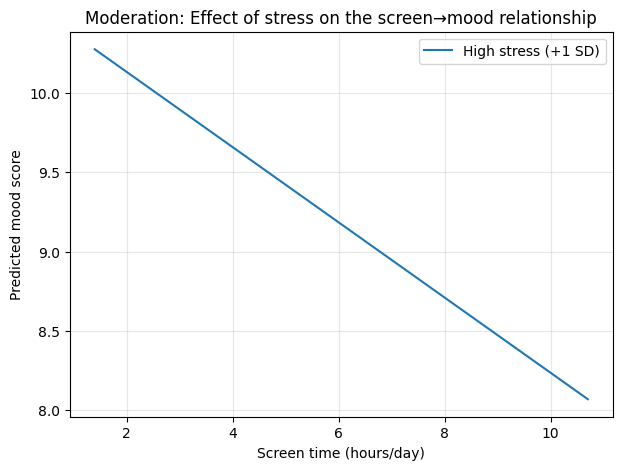

In [29]:

assert 'mod_df' in globals() and 'int_mod' in globals(), "Run the Moderation cell first."


x_min, x_max = np.percentile(mod_df["screen_time_hours"], [1, 99])
grid_screen = np.linspace(x_min, x_max, 100)


s_mean = mod_df["stress_level"].mean()
s_sd   = mod_df["stress_level"].std()
stress_levels = {
    "Low stress (−1 SD)": s_mean - s_sd,
    "Mid stress (mean)":  s_mean,
    "High stress (+1 SD)": s_mean + s_sd
}


sleep_mean  = mod_df["sleep_hours"].mean()
tiktok_mean = mod_df["hours_on_TikTok"].mean()
plat_mean   = mod_df["social_media_platforms_used"].mean()


def center(series, mean): return series - mean

pred_lines = {}
for label, s_raw in stress_levels.items():
    df_pred = pd.DataFrame({
        "screen_time_hours": grid_screen,
        "sleep_hours": np.full_like(grid_screen, sleep_mean),
        "stress_level": np.full_like(grid_screen, s_raw),
        "hours_on_TikTok": np.full_like(grid_screen, tiktok_mean),
        "social_media_platforms_used": np.full_like(grid_screen, plat_mean),
    })

    df_pred["screen_time_hours_c"] = center(df_pred["screen_time_hours"], mod_df["screen_time_hours"].mean())
    df_pred["sleep_hours_c"] = center(df_pred["sleep_hours"], mod_df["sleep_hours"].mean())
    df_pred["stress_level_c"] = center(df_pred["stress_level"], mod_df["stress_level"].mean())
    df_pred["hours_on_TikTok_c"] = center(df_pred["hours_on_TikTok"], mod_df["hours_on_TikTok"].mean())
    df_pred["social_media_platforms_used_c"] = center(df_pred["social_media_platforms_used"], mod_df["social_media_platforms_used"].mean())


df_pred["sx_stress"] = df_pred["screen_time_hours_c"] * df_pred["stress_level_c"]


Xp = sm.add_constant(
    df_pred[["screen_time_hours_c","sleep_hours_c","stress_level_c",
             "hours_on_TikTok_c","social_media_platforms_used_c","sx_stress"]],
    has_constant="add"
)
Xp = Xp.reindex(columns=int_mod.model.exog_names, fill_value=0.0)

pred_lines[label] = (grid_screen, int_mod.predict(Xp))

# Plot
plt.figure(figsize=(7,5))
for label, (xs, ys) in pred_lines.items():
    plt.plot(xs, ys, label=label)
plt.xlabel("Screen time (hours/day)")
plt.ylabel("Predicted mood score")
plt.title("Moderation: Effect of stress on the screen→mood relationship")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Conclusion from Moderation Plot

- At **high stress (+1 SD)**, predicted **mood decreases steadily** as **screen time** increases — the slope is clearly negative.
- This supports **moderation**: when stress is high, the screen→mood association appears **more harmful** (i.e., a **steeper decline** in mood with additional screen time).


### Mediation Visualization: Mood vs Sleep at Low vs High Screen Time

This cell plots **predicted mood vs. sleep_hours** for two screen-time scenarios: **low screen (−1 SD)** and **high screen (+1 SD)**.  
It builds a sleep grid, centers variables to match the mediation model `Y ~ Mc + Xc` (`bc_mod`), predicts mood for each scenario, and overlays the two lines.  
Interpretation: if the lines are **well separated** at the same sleep level, screen time has a **direct** association beyond sleep; if they’re **nearly overlapping**, the screen→mood link is largely explained by **sleep** (stronger mediation).


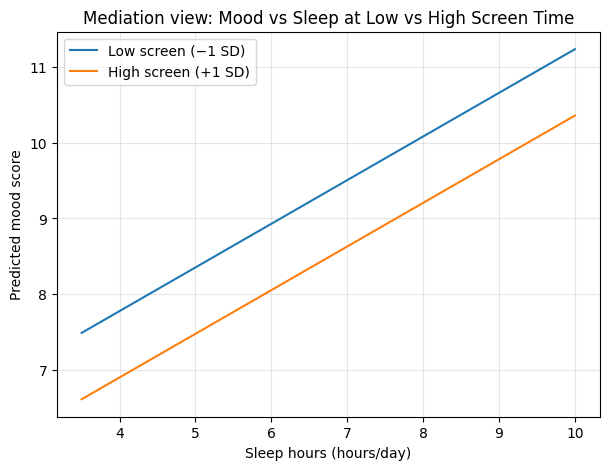

In [ ]:
X_mean = med_df["X"].mean()
X_sd   = med_df["X"].std()
scenarios = {
    "Low screen (−1 SD)": X_mean - X_sd,
    "High screen (+1 SD)": X_mean + X_sd
}

M_grid = np.linspace(np.percentile(med_df["M"], 1), np.percentile(med_df["M"], 99), 100)

plt.figure(figsize=(7,5))
for label, X_raw in scenarios.items():
    Mc = M_grid - med_df["M"].mean()
    Xc = np.full_like(M_grid, X_raw - med_df["X"].mean())


    Xp = pd.DataFrame({"const": 1.0, "Mc": Mc, "Xc": Xc})
    Xp = Xp.reindex(columns=bc_mod.model.exog_names, fill_value=0.0)
    if "const" in Xp.columns:
        Xp["const"] = 1.0

    yhat = bc_mod.predict(Xp)
    plt.plot(M_grid, yhat, label=label)

plt.xlabel("Sleep hours (hours/day)")
plt.ylabel("Predicted mood score")
plt.title("Mediation view: Mood vs Sleep at Low vs High Screen Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**What we add:**  
- Creates three derived features: `sleep_deficit = max(0, 8 - sleep_hours)`, `screen_to_sleep_ratio = screen_time_hours / sleep_hours` (with 0/NaN handled and extreme top 1% winsorized), and `social_share_tiktok = hours_on_TikTok / screen_time_hours` (0/NaN→0, clipped to [0,1]).  
- These are meant to capture (a) insufficient sleep, (b) how much screen time dominates the day relative to sleep, and (c) the share of total screen time that is TikTok.

**Diagnostics it runs:**  
- Prints **Pearson** and **Spearman** correlation matrices for the core variables plus the new ones to see basic associations and potential redundancy.  
- Computes **Variance Inflation Factors (VIF)**: fills medians, standardizes predictors, then reports VIF for each feature and flags any **VIF > 5** (potential multicollinearity).

**How to use the results:**  
- If you see high VIF for combinations like `sleep_hours` with `sleep_deficit` or `screen_time_hours` with `screen_to_sleep_ratio`, don’t keep both in the same model. Prefer the raw components OR a single ratio, not both, to keep estimates stable.

In [31]:


fe = (analysis_df if 'analysis_df' in globals() else df).copy()


fe["sleep_deficit"] = np.clip(8.0 - fe["sleep_hours"], 0, None)

fe["screen_to_sleep_ratio"] = fe["screen_time_hours"] / fe["sleep_hours"].replace({0: np.nan})
fe.loc[~np.isfinite(fe["screen_to_sleep_ratio"]), "screen_to_sleep_ratio"] = np.nan

q99 = fe["screen_to_sleep_ratio"].quantile(0.99, interpolation="linear")
fe["screen_to_sleep_ratio"] = fe["screen_to_sleep_ratio"].clip(upper=q99)

fe["social_share_tiktok"] = (fe["hours_on_TikTok"] / fe["screen_time_hours"].replace({0: np.nan})).clip(0,1)


core = ["screen_time_hours","sleep_hours","hours_on_TikTok",
        "social_media_platforms_used","stress_level","mood_score"]
newf = ["sleep_deficit","screen_to_sleep_ratio","social_share_tiktok"]

print("Pearson correlations:")
display(fe[core+newf].corr(method="pearson").style.background_gradient(axis=None, cmap="coolwarm").format("{:.2f}"))
print("Spearman correlations:")
display(fe[core+newf].corr(method="spearman").style.background_gradient(axis=None, cmap="coolwarm").format("{:.2f}"))

vif_predictors = ["screen_time_hours","sleep_hours","hours_on_TikTok",
                  "social_media_platforms_used","sleep_deficit",
                  "screen_to_sleep_ratio","social_share_tiktok"]

X = fe[vif_predictors].copy()


X_imp = X.fillna(X.median(numeric_only=True))


scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_imp), columns=vif_predictors, index=X_imp.index)


vif_rows = []
for i, col in enumerate(X_std.columns):
    try:
        v = variance_inflation_factor(X_std.values, i)
    except Exception:
        v = np.nan
    vif_rows.append({"feature": col, "VIF": float(v)})

vif_df = pd.DataFrame(vif_rows).sort_values("VIF", ascending=False)
print("Variance Inflation Factors (VIF):")
display(vif_df)


high_vif = vif_df[vif_df["VIF"] > 5]["feature"].tolist()
if high_vif:
    print("High VIF (>5):", high_vif, "\nTips:\n- Don’t include BOTH sleep_hours and sleep_deficit together.\n- Drop screen_to_sleep_ratio if you already include its components.")
else:
    print("No severe collinearity (VIF > 5).")


Pearson correlations:


,screen_time_hours,sleep_hours,hours_on_TikTok,social_media_platforms_used,stress_level,mood_score,sleep_deficit,screen_to_sleep_ratio,social_share_tiktok
screen_time_hours,1.00,0.00,0.74,0.00,0.49,-0.34,0.00,0.80,-0.00
sleep_hours,0.00,1.00,-0.00,0.00,-0.69,0.66,-0.96,-0.56,-0.01
hours_on_TikTok,0.74,-0.00,1.00,0.00,0.48,-0.34,0.00,0.59,0.64
social_media_platforms_used,0.00,0.00,0.00,1.00,0.00,0.00,-0.00,0.00,0.00
stress_level,0.49,-0.69,0.48,0.00,1.00,-0.64,0.66,0.77,0.16
mood_score,-0.34,0.66,-0.34,0.00,-0.64,1.00,-0.69,-0.70,-0.12
sleep_deficit,0.00,-0.96,0.00,-0.00,0.66,-0.69,1.00,0.57,0.00
screen_to_sleep_ratio,0.80,-0.56,0.59,0.00,0.77,-0.70,0.57,1.00,0.00
social_share_tiktok,-0.00,-0.01,0.64,0.00,0.16,-0.12,0.00,0.00,1.00


Spearman correlations:


,screen_time_hours,sleep_hours,hours_on_TikTok,social_media_platforms_used,stress_level,mood_score,sleep_deficit,screen_to_sleep_ratio,social_share_tiktok
screen_time_hours,1.00,0.00,0.72,0.00,0.48,-0.34,-0.00,0.82,-0.00
sleep_hours,0.00,1.00,-0.00,0.00,-0.68,0.67,-0.99,-0.51,-0.00
hours_on_TikTok,0.72,-0.00,1.00,0.00,0.46,-0.32,0.00,0.61,0.65
social_media_platforms_used,0.00,0.00,0.00,1.00,0.00,0.00,-0.00,0.00,0.00
stress_level,0.48,-0.68,0.46,0.00,1.00,-0.66,0.67,0.77,0.16
mood_score,-0.34,0.67,-0.32,0.00,-0.66,1.00,-0.67,-0.66,-0.11
sleep_deficit,-0.00,-0.99,0.00,-0.00,0.67,-0.67,1.00,0.51,0.00
screen_to_sleep_ratio,0.82,-0.51,0.61,0.00,0.77,-0.66,0.51,1.00,0.00
social_share_tiktok,-0.00,-0.00,0.65,0.00,0.16,-0.11,0.00,0.00,1.00


Variance Inflation Factors (VIF):


,feature,VIF
0,screen_time_hours,27.955649
5,screen_to_sleep_ratio,23.919945
2,hours_on_TikTok,21.943405
4,sleep_deficit,15.712006
1,sleep_hours,12.428777
6,social_share_tiktok,10.033368
3,social_media_platforms_used,1.000055


High VIF (>5): ['screen_time_hours', 'screen_to_sleep_ratio', 'hours_on_TikTok', 'sleep_deficit', 'sleep_hours', 'social_share_tiktok'] 
Tips:
- Don’t include BOTH sleep_hours and sleep_deficit together.
- Drop screen_to_sleep_ratio if you already include its components.




- Builds polished visualizations to **tell the story honestly**.
- Creates two scatter + LOESS trend plots:  
  1) *Mood vs Screen Time* stratified by **stress tertiles**;  
  2) *Mood vs Sleep* stratified by **TikTok share of screen time** (with a 7–8h sleep band annotated).
- Trains a simple Gradient Boosting model and outputs **PDP/ICE** plots for *sleep_hours* and *screen_time_hours* to show partial effects and individual heterogeneity.  
All figures are saved under `/content/figures/`.


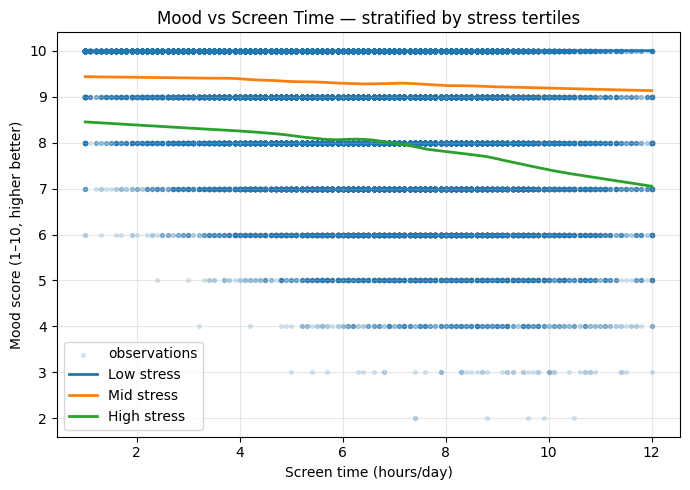

Saved: /content/figures/mood_vs_screen_loess_by_stress.png


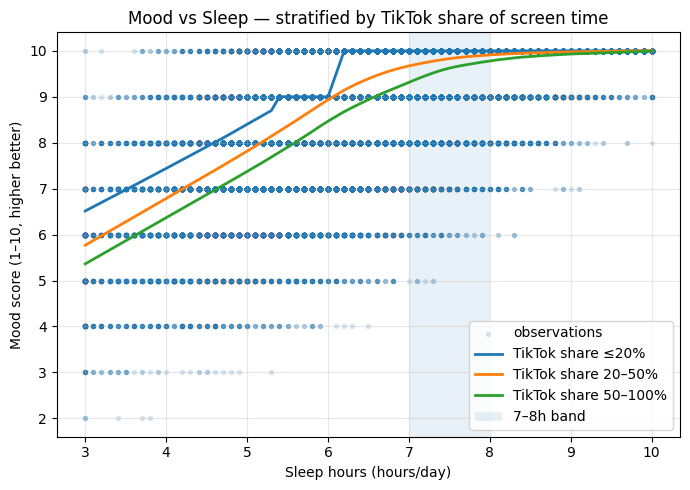

Saved: /content/figures/mood_vs_sleep_loess_by_share.png


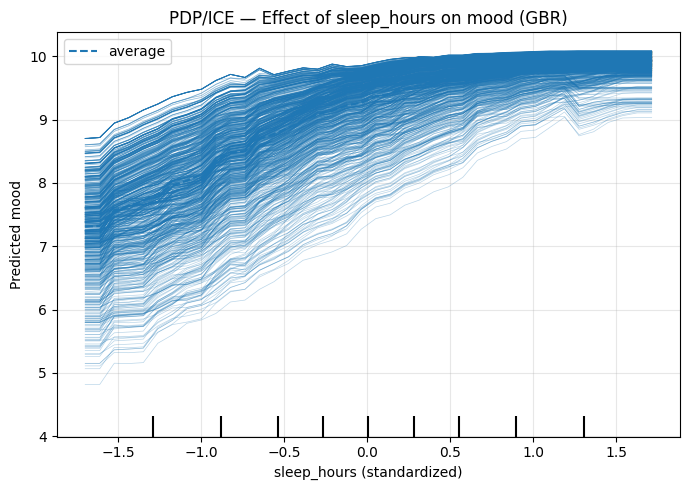

Saved: /content/figures/pdp_ice_sleep_hours.png


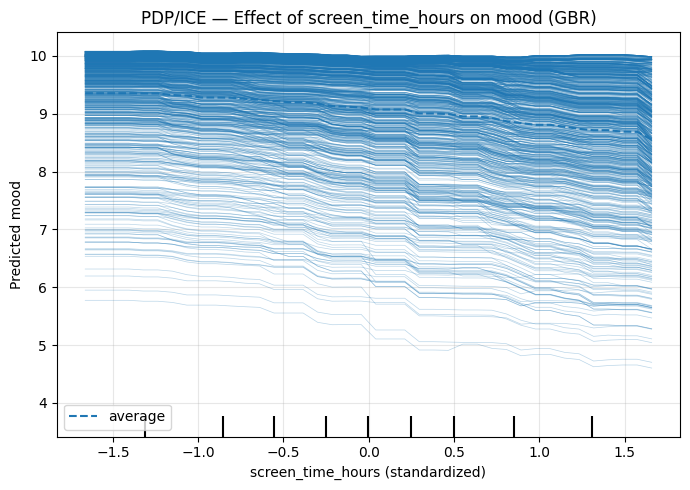

Saved: /content/figures/pdp_ice_screen_time.png

Files ready for slides:
 - /content/figures/mood_vs_screen_loess_by_stress.png
 - /content/figures/mood_vs_sleep_loess_by_share.png
 - /content/figures/pdp_ice_sleep_hours.png
 - /content/figures/pdp_ice_screen_time.png


In [33]:

data = analysis_df if 'analysis_df' in globals() else df
figdir = Path("/content/figures"); figdir.mkdir(parents=True, exist_ok=True)


def loess_line(x, y, frac=0.3):
    ok = np.isfinite(x) & np.isfinite(y)
    if ok.sum() < 5:
        return None
    sm = lowess(y[ok], x[ok], frac=frac, return_sorted=True)
    return sm[:,0], sm[:,1]

def strat_labels_from_tertiles(s, labels=("Low","Mid","High")):
    q = pd.qcut(s, 3, labels=labels, duplicates="drop")
    return q

def bucket_from_share(s, bins=(0.0, 0.2, 0.5, 1.0), labels=("≤20%", "20–50%", "50–100%")):

    b = pd.cut(s.clip(0,1), bins=bins, labels=labels, include_lowest=True)
    return b


social_share = (data["hours_on_TikTok"] / data["screen_time_hours"].replace({0: np.nan})).clip(0,1)


plot_df = data[["mood_score","screen_time_hours","stress_level"]].dropna().copy()
plot_df["stress_tertile"] = strat_labels_from_tertiles(plot_df["stress_level"])

plt.figure(figsize=(7,5))

plt.scatter(plot_df["screen_time_hours"], plot_df["mood_score"], s=8, alpha=0.15, label="observations")

for label in ("Low","Mid","High"):
    sub = plot_df[plot_df["stress_tertile"]==label]
    ln = loess_line(sub["screen_time_hours"].values, sub["mood_score"].values, frac=0.25)
    if ln:
        xs, ys = ln
        plt.plot(xs, ys, linewidth=2, label=f"{label} stress")

plt.xlabel("Screen time (hours/day)")
plt.ylabel("Mood score (1–10, higher better)")
plt.title("Mood vs Screen Time — stratified by stress tertiles")
plt.legend()
plt.grid(True, alpha=0.3)
out1 = figdir/"mood_vs_screen_loess_by_stress.png"
plt.tight_layout(); plt.savefig(out1, dpi=160); plt.show()
print("Saved:", out1)


plot2 = data[["mood_score","sleep_hours","screen_time_hours","hours_on_TikTok"]].dropna().copy()
plot2["social_share"] = (plot2["hours_on_TikTok"]/plot2["screen_time_hours"].replace({0:np.nan})).clip(0,1)
plot2["share_bucket"] = bucket_from_share(plot2["social_share"])

plt.figure(figsize=(7,5))
plt.scatter(plot2["sleep_hours"], plot2["mood_score"], s=8, alpha=0.15, label="observations")

for label in plot2["share_bucket"].cat.categories:
    sub = plot2[plot2["share_bucket"]==label]
    ln = loess_line(sub["sleep_hours"].values, sub["mood_score"].values, frac=0.25)
    if ln:
        xs, ys = ln
        plt.plot(xs, ys, linewidth=2, label=f"TikTok share {label}")


plt.axvspan(7, 8, alpha=0.1, hatch="//", edgecolor="none", label="7–8h band")
plt.xlabel("Sleep hours (hours/day)")
plt.ylabel("Mood score (1–10, higher better)")
plt.title("Mood vs Sleep — stratified by TikTok share of screen time")
plt.legend()
plt.grid(True, alpha=0.3)
out2 = figdir/"mood_vs_sleep_loess_by_share.png"
plt.tight_layout(); plt.savefig(out2, dpi=160); plt.show()
print("Saved:", out2)

core_feats = ["sleep_hours","screen_time_hours","hours_on_TikTok","social_media_platforms_used","stress_level"]
pdp_df = data[core_feats + ["mood_score"]].dropna().copy()
X = pd.get_dummies(pdp_df[core_feats], drop_first=False)
y = pdp_df["mood_score"].astype(float)


scaler = StandardScaler()
Xs = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

Xtr, Xte, ytr, yte = train_test_split(Xs, y, test_size=0.2, random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(Xtr, ytr)

fig, ax = plt.subplots(figsize=(7,5))
PartialDependenceDisplay.from_estimator(
    gbr, Xs, features=[Xs.columns.get_loc("sleep_hours")], kind="both",
    grid_resolution=40, ax=ax
)
plt.title("PDP/ICE — Effect of sleep_hours on mood (GBR)")
plt.xlabel("sleep_hours (standardized)")
plt.ylabel("Predicted mood")
plt.grid(True, alpha=0.3)
out3 = figdir/"pdp_ice_sleep_hours.png"
plt.tight_layout(); plt.savefig(out3, dpi=160); plt.show()
print("Saved:", out3)

fig, ax = plt.subplots(figsize=(7,5))
PartialDependenceDisplay.from_estimator(
    gbr, Xs, features=[Xs.columns.get_loc("screen_time_hours")], kind="both",
    grid_resolution=40, ax=ax
)
plt.title("PDP/ICE — Effect of screen_time_hours on mood (GBR)")
plt.xlabel("screen_time_hours (standardized)")
plt.ylabel("Predicted mood")
plt.grid(True, alpha=0.3)
out4 = figdir/"pdp_ice_screen_time.png"
plt.tight_layout(); plt.savefig(out4, dpi=160); plt.show()
print("Saved:", out4)

print("\nFiles ready for slides:")
for p in [out1, out2, out3, out4]:
    print(" -", p)


## Key takeaways from the graphs

- **Screen time vs mood (by stress):** Mood trends downward as screen time rises; the decline is **steeper at higher stress**, supporting stress-as-moderator.
- **Sleep vs mood (by TikTok share):** More sleep → higher mood, with a **notable plateau around 7–8 hours**. High TikTok share tracks a **lower overall mood curve**.
- **PDP/ICE (GBR):** Partial dependence shows **monotonic gains with sleep** (diminishing after ~7–8h) and **flat-to-slightly negative effect of higher screen time**; ICE lines reveal **person-to-person variability** in both effects.



## Final Correlations

**Against mood_score (1–10, higher = better):**
- sleep_hours ↔ mood_score: **+0.67** (strong positive)
- stress_level ↔ mood_score: **−0.68** (strong negative)
- screen_time_hours ↔ mood_score: **−0.33** (modest negative)
- hours_on_TikTok ↔ mood_score: **−0.32** (modest negative)
- social_media_platforms_used ↔ mood_score: **~0.00** (negligible)

**Other notable pairs:**
- screen_time_hours ↔ hours_on_TikTok: **+0.72** (high)
- screen_time_hours ↔ stress_level: **+0.48** (moderate)
- sleep_hours ↔ stress_level: **−0.68** (strong)
- screen_time_hours ↔ sleep_hours: **~0.00** (negligible)
- social_media_platforms_used with others: **~0** (generally negligible)

*Note:* These are associative (not causal) and summarized from your run’s Spearman matrix; rounding ≈ 2 decimals.


## To Conclude

- **Sleep is the strongest correlate of mood.** Across OLS, splines, and ordered models, more sleep ↔ higher mood; partial-dependence indicates benefits taper around **~7–8 hours/night**.
- **Screen time shows a modest negative association**, and **hours on TikTok** add an *additional* negative effect beyond total screen time. Platform count contributes little.
- **Nonlinearity matters:** spline models improve fit (**CV R² ≈ 0.63** vs **~0.55** for simpler models), capturing a sleep plateau and a gently worsening trend with higher screen time.
- **Mediation via sleep is negligible** in this cross-section (indirect path *a×b* ≈ 0; bootstrap CI spans 0).
- **Stress moderates the screen→mood link:** at **high stress (+1 SD)**, the slope is more negative (steeper decline in mood with more screen time).
- **Predictive performance is reasonable, not perfect:** best **CV R² ≈ 0.63**, **RMSE ≈ 0.78** on the 1–10 mood scale—useful for group-level inference, not individual prognosis.

